In [159]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torch import nn
from torch.nn import functional as F

In [165]:
class Net(torch.nn.Module):
    
    def __init__(self, n_input, n_hidden, n_output):
        super(Net, self).__init__()
        torch.manual_seed(2)
        self.layer1 = torch.nn.Linear(n_input, n_hidden)
        self.layer2 = torch.nn.Linear(n_hidden, n_hidden)
        self.layer3 = torch.nn.Linear(n_hidden, n_hidden)
        self.layer4 = torch.nn.Linear(n_hidden, n_output)
        
    def forward(self, x):
        tanFunc = torch.nn.Tanh()
        h_1 = tanFunc(self.layer1(x))
        h_2 = tanFunc(self.layer2(h_1))
        h_3 = tanFunc(self.layer3(h_2))
        out = self.layer4(h_3)
        return out
    
    

In [166]:
device = torch.device("cuda:0")

print("Reading...")
test = pd.read_csv('/Users/richardhoffmann/Downloads/neural_inputs.csv')
train = pd.read_csv('/Users/richardhoffmann/Downloads/y_data.csv')

print("Converting...")
test_tensor = torch.Tensor(test.values)
train_tensor = torch.Tensor(train.values)

Reading...
Converting...


In [167]:

y = train_tensor
x_all = test_tensor
x = x_all[:, [0, 1, 4, 5, 6]] #speed yaw syteering v_x v_y
#add time

# print(test)
# print(train)
# print(x)
# print(y)


In [171]:
# loss without any training
model = Net(5, 36, 2)
ind = torch.randperm(len(x))[:9000] #there are alot of duplicates
print(len(ind.tolist()))
train_x = x[ind]

test_ind =  list(set(total_num) - set(ind.tolist()))
# print (len(test_ind))
test_x = x[test_ind]

test_y = model(test_x)
l2loss_test = torch.sum(torch.square(test_y - y[test_ind][:,[0,1]]))/len(test_y)
print(test_y)
print(y[test_ind][:,[0,1]])
print(l2loss_test)

9000
tensor([[-0.1212,  0.1590],
        [-0.1204,  0.1321],
        [-0.1213,  0.1377],
        ...,
        [ 0.0409,  0.2228],
        [-0.0128,  0.2286],
        [-0.0139,  0.2238]], grad_fn=<AddmmBackward0>)
tensor([[ 4.0518,  5.3473],
        [-2.1956, -2.8986],
        [ 1.3602,  1.7957],
        ...,
        [ 0.6896, -0.7476],
        [ 0.7876, -0.5781],
        [ 0.8273, -0.4997]])
tensor(3.2402, grad_fn=<DivBackward0>)


In [67]:
# untrained_y = model(x)


In [100]:
# train_x = x[0:9000] #select 9000 random samples instead 
model = Net(5, 36, 2)
ind = torch.randperm(len(x))[:9000] #there are alot of duplicates
print(len(ind.tolist()))
train_x = x[ind]

total_num = list(range(0, 12100))
test_ind =  list(set(total_num) - set(ind.tolist()))
# print (len(test_ind))
test_x = x[test_ind]
loss_arr = []
max_iters = 2000
test_loss_arr = []
j = 0
i = 0
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
while i < max_iters:
#     print (ind)
    train_y = model(train_x)
    l2loss = torch.sum(torch.square(train_y - y[ind][:,[0,1]]))/len(train_y) #rho*torch.square(train_y - y[ind][:,[2]])
    optimizer.zero_grad()
    l2loss.backward()
    optimizer.step()
    loss_arr.append(l2loss.item())
    if (j %25 == 0):
        test_y = model(test_x)
        l2loss_test = torch.sum(torch.square(test_y - y[test_ind][:,[0,1]]))/len(test_y)
        test_loss_arr.append(l2loss_test)
        
    j += 1
    i += 1
    
  


9000


In [101]:
new_test_loss = [value.detach().numpy() for value in test_loss_arr]
print(new_test_loss[1])

2.369507


80


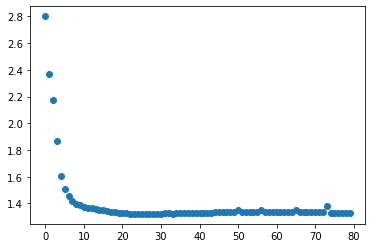

In [102]:
fig, ax = plt.subplots()
# new_test_loss = [value.detach().numpy() for value in test_loss_arr]
print(len(new_test_loss))
ax.scatter(range(0, len(new_test_loss), 1), new_test_loss)
plt.show()

In [103]:
print (np.min(new_test_loss))
print (np.argmin(new_test_loss))

1.3212646
27


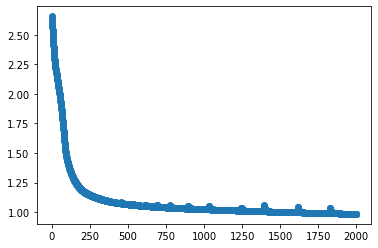

In [71]:
fig, ax = plt.subplots()
ax.scatter(range(0, len(loss_arr), 1), loss_arr)
plt.show()

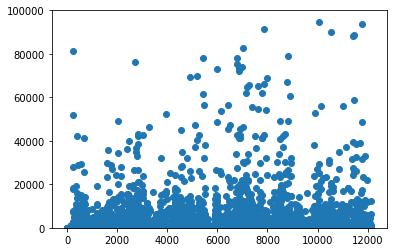

(array([8475,  457, 1022, 2182,   12]), array([               0,               50,              100,
                    500,           100000, 1000000000000000]))
tensor(30957752.)


In [111]:
#This is L2 loss of the completete dataset  inlcuding yaw

# print(test_x[:,[0]])
# print(test_x[:,[1]])
# print(test_x[:,[0]]*test_x[:,[1]])
kin_x_dot = x[:,[0]]*torch.cos(x[:,[1]])
# print(len(kin_x_dot))
kin_y_dot = x[:,[0]]*torch.sin(x[:,[1]])
kin_t_dot = x[:,[0]]*torch.tan(x[:,[2]])/0.33
kin_error = torch.sum(torch.square(kin_x_dot - y[:,[0]]))+  torch.sum(torch.square(kin_y_dot - y[:,[1]])+torch.sum(torch.square(kin_y_dot - y[:,[2]])))  

total_error_arr = torch.square(kin_x_dot - y[:,[0]])+torch.square(kin_y_dot - y[:,[1]]) +torch.square(kin_y_dot - y[:,[2]])
fig, ax = plt.subplots()
ax.scatter(range(0, len(kin_x_dot), 1), torch.square(kin_x_dot - y[:,[0]])+torch.square(kin_y_dot - y[:,[1]]) +torch.square(kin_y_dot - y[:,[2]]))
plt.ylim([0,100000])
plt.show()

np_total_err = total_error_arr.numpy()
hist = np.histogram(np_total_err, bins=[0, 50, 100, 500, 100000, 1000000000000000])
print(hist)

print(kin_error/len(x))

In [112]:
model = Net(5, 36, 3)
ind = torch.randperm(len(x))[:9000] #there are alot of duplicates
print(len(ind.tolist()))
train_x = x[ind]

total_num = list(range(0, 12100))
test_ind =  list(set(total_num) - set(ind.tolist()))
# print (len(test_ind))
test_x = x[test_ind]
loss_arr = []
max_iters = 2000
test_loss_arr = []
j = 0
i = 0
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
while i < max_iters:
#     print (ind)
    train_y = model(train_x)
    l2loss = torch.sum(torch.square(train_y - y[ind]))/len(train_y) #rho*torch.square(train_y - y[ind][:,[2]])
    optimizer.zero_grad()
    l2loss.backward()
    optimizer.step()
    loss_arr.append(l2loss.item())
    
    if (j %25 == 0):
        test_y = model(test_x)
        l2loss_test = torch.sum(torch.square(test_y - y[test_ind]))/len(test_y)
        test_loss_arr.append(l2loss_test)

        
    j += 1
    i += 1
    
  

9000


80


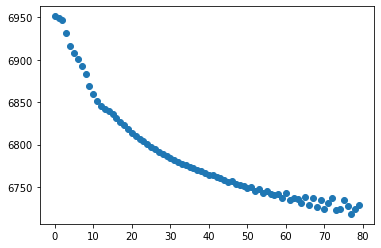

In [113]:
new_test_loss = [value.detach().numpy() for value in test_loss_arr]
fig, ax = plt.subplots()
# new_test_loss = [value.detach().numpy() for value in test_loss_arr]
print(len(new_test_loss))
ax.scatter(range(0, len(new_test_loss), 1), new_test_loss)
plt.show()

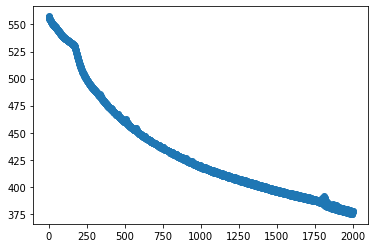

In [90]:
fig, ax = plt.subplots()
ax.scatter(range(0, len(loss_arr), 1), loss_arr)
plt.show()

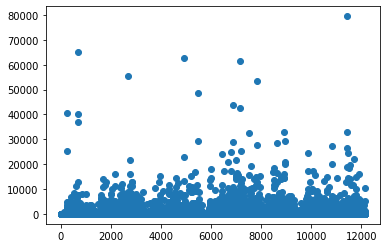

(array([9146,  366, 1039, 1597]), array([     0,     50,    100,    500, 100000]))
tensor(2600.9436)


In [144]:
# print(test_x[:,[0]])
# print(test_x[:,[1]])
# print(test_x[:,[0]]*test_x[:,[1]])
kin_x_dot = x[:,[0]]*torch.cos(x[:,[1]])
# print(len(kin_x_dot))
kin_y_dot = x[:,[0]]*torch.sin(x[:,[1]])
kin_error = torch.sum(torch.square(kin_x_dot - y[:,[0]]))+  torch.sum(torch.square(kin_y_dot - y[:,[1]]))  

fig, ax = plt.subplots()
ax.scatter(range(0, len(kin_x_dot), 1), torch.square(kin_x_dot - y[:,[0]])+torch.square(kin_y_dot - y[:,[1]]))
plt.show()

trans_err =torch.square(kin_x_dot - y[:,[0]])+torch.square(kin_y_dot - y[:,[1]])
np_trans_err = trans_err.numpy()
hist = np.histogram(np_trans_err, bins=[0, 50, 100, 500, 100000])
print(hist)

print(kin_error/len(test_x))

In [115]:
print(kin_x_dot)
print(kin_y_dot)
print(y[test_ind][:,[0,1]])
# print(test_ind)

tensor([[-0.0014],
        [-0.0030],
        [ 1.1249],
        ...,
        [ 0.1838],
        [ 0.9367],
        [ 0.9211]])
tensor([[ 0.0020],
        [ 0.0055],
        [-0.5814],
        ...,
        [-1.5197],
        [-1.0715],
        [-0.9490]])
tensor([[-2.1956, -2.8986],
        [-0.8720, -1.1511],
        [ 0.8913, -0.2316],
        ...,
        [ 0.3583, -1.0459],
        [ 0.7876, -0.5781],
        [ 0.8232, -0.5297]])


tensor([[4.8142],
        [0.7551],
        [0.0546],
        ...,
        [0.0305],
        [0.0222],
        [0.0096]])


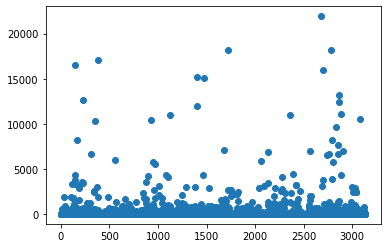

In [116]:
x_error_arr = torch.square(kin_x_dot - y[test_ind][:,[0]])
print(x_error_arr)
fig, ax = plt.subplots()
ax.scatter(range(0, len(x_error_arr), 1), x_error_arr)
plt.show()

In [117]:
print(torch.argmax(x_error_arr))
print(x_error_arr[1690])
print(kin_x_dot[1690])
print(kin_y_dot[1690])
print(y[test_ind][1690,[0,1]])


print("speed: ", test_x[1690,[0]])
print("yaw: ", test_x[1690,[1]])

tensor(2678)
tensor([0.2572])
tensor([1.8327])
tensor([-0.6798])
tensor([ 2.3399, -0.6532])
speed:  tensor([1.9548])
yaw:  tensor([-0.3552])


In [118]:
np_x_err = x_error_arr.numpy()
hist = np.histogram(np_x_err, bins=[0, 50, 100, 500, 100000])
print(hist)

(array([2604,  100,  202,  230]), array([     0,     50,    100,    500, 100000]))


In [119]:
print (np.min(new_test_loss))
print (np.argmin(new_test_loss))

6718.304
77


(array([9146,  366, 1039, 1597]), array([     0,     50,    100,    500, 100000]))
kinamatic average error: 3.395375198174065
tensor([[ 6.3566e-04,  1.2640e+00,  0.0000e+00, -5.6392e-04,  2.9335e-04],
        [ 2.4746e-03,  2.1894e+00,  0.0000e+00, -8.5896e-04, -2.3208e-03],
        [ 1.2155e-03,  1.9385e+00, -3.0689e-07,  1.2125e-03, -8.5495e-05],
        ...,
        [ 1.9342e-01,  2.5889e+00,  0.0000e+00,  1.8977e-01, -3.7383e-02],
        [ 3.0749e-01,  2.5262e+00,  0.0000e+00,  3.0079e-01, -6.3845e-02],
        [ 3.0914e-01,  2.6388e+00,  0.0000e+00,  3.0912e-01,  3.9320e-03]])
9146


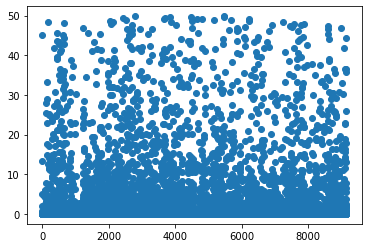

In [120]:
#remove anything with a kinmatic L2 norm over 50
kin_x_dot = x[:,[0]]*torch.cos(x[:,[1]])
# print(len(kin_x_dot))
kin_y_dot = x[:,[0]]*torch.sin(x[:,[1]])
kin_error = torch.square(kin_x_dot - y[:,[0]])+ torch.square(kin_y_dot - y[:,[1]])
np_kin_err = kin_error.numpy()
hist = np.histogram(np_kin_err, bins=[0, 50, 100, 500, 100000])
print(hist)
#this hist shows that 9000ish samples are within 0-50 L2 norm, so we will remove everything larger
good_ind = []
for i, val in enumerate(np_kin_err):
    if val < 50:
        good_ind.append(i)

# print(bad_ind)
# print(len(bad_ind))

#now we have all the bad ind, renomve from all data

downsampled_x = x[good_ind,:]
downsampled_y = y[good_ind,:]
downsampled_kin = np_kin_err[good_ind,:]
print("kinamatic average error:", np.sum(downsampled_kin)/len(downsampled_kin))
print(downsampled_x)
print(len(downsampled_x))

fig, ax = plt.subplots()
ax.scatter(range(0, len(good_ind), 1), np_kin_err[good_ind])
plt.show()

In [121]:
#retrain network on downsampled x
# train_x = x[0:9000] #select 9000 random samples instead 

#reinit model
model = Net(5, 36, 2)

ind = torch.randperm(len(downsampled_x))[:int(0.7*len(downsampled_x))] #there are alot of duplicates
# print(len(ind.tolist()))
train_x = downsampled_x[ind]

total_num = list(range(0, len(downsampled_x)))
test_ind =  list(set(total_num) - set(ind.tolist()))
# print (len(test_ind))
test_x = downsampled_x[test_ind]
loss_arr = []
max_iters = 1700
test_loss_arr = []
j = 0
i = 0
count = 0
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
while i < max_iters:
#     print (ind)
    train_y = model(train_x)
    l2loss = torch.sum(torch.square(train_y - downsampled_y[ind][:,[0,1]])) / len(train_y) #rho*torch.square(train_y - y[ind][:,[2]])
    optimizer.zero_grad()
    l2loss.backward()
    optimizer.step()
    loss_arr.append(l2loss.item())
    
    if (j %50 == 0):
        test_y = model(test_x)
        l2loss_test = torch.sum(torch.square(test_y - downsampled_y[test_ind][:,[0,1]]))/len(test_y)
        test_loss_arr.append(l2loss_test)
        count += 1
        
    j += 1
    i += 1
    
print (count)


34


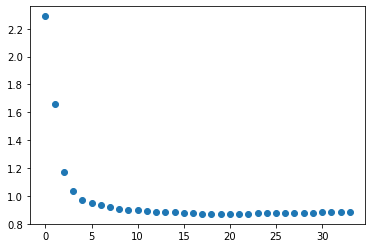

[array(2.289775, dtype=float32), array(1.6579419, dtype=float32), array(1.1687591, dtype=float32), array(1.0327079, dtype=float32), array(0.9718503, dtype=float32), array(0.9484486, dtype=float32), array(0.93406355, dtype=float32), array(0.9203534, dtype=float32), array(0.90840644, dtype=float32), array(0.9001066, dtype=float32), array(0.89489174, dtype=float32), array(0.88985515, dtype=float32), array(0.8850065, dtype=float32), array(0.88098717, dtype=float32), array(0.8819371, dtype=float32), array(0.87536585, dtype=float32), array(0.87342304, dtype=float32), array(0.87188953, dtype=float32), array(0.87118715, dtype=float32), array(0.8701699, dtype=float32), array(0.87056106, dtype=float32), array(0.87141424, dtype=float32), array(0.8725954, dtype=float32), array(0.8742013, dtype=float32), array(0.8757877, dtype=float32), array(0.87813914, dtype=float32), array(0.8802033, dtype=float32), array(0.87884486, dtype=float32), array(0.8800759, dtype=float32), array(0.880267, dtype=float32)

In [122]:
#fig, ax = plt.subplots()
new_test_loss = [value.detach().numpy() for value in test_loss_arr]
# print(new_test_loss)
fig, ax = plt.subplots()
ax.scatter(range(0, len(new_test_loss), 1), new_test_loss)
plt.show()
print(new_test_loss)

In [123]:
print(np.min(new_test_loss))
print(np.argmin(new_test_loss))

0.8701699
19


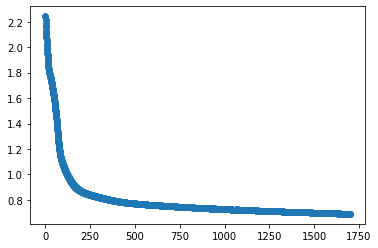

In [124]:
fig, ax = plt.subplots()
ax.scatter(range(0, len(loss_arr), 1), loss_arr)
plt.show()

[array(2.289775, dtype=float32), array(1.6579419, dtype=float32), array(1.1687591, dtype=float32), array(1.0327079, dtype=float32), array(0.9718503, dtype=float32), array(0.9484486, dtype=float32), array(0.93406355, dtype=float32), array(0.9203534, dtype=float32), array(0.90840644, dtype=float32), array(0.9001066, dtype=float32), array(0.89489174, dtype=float32), array(0.88985515, dtype=float32), array(0.8850065, dtype=float32), array(0.88098717, dtype=float32), array(0.8819371, dtype=float32), array(0.87536585, dtype=float32), array(0.87342304, dtype=float32), array(0.87188953, dtype=float32), array(0.87118715, dtype=float32), array(0.8701699, dtype=float32), array(0.87056106, dtype=float32), array(0.87141424, dtype=float32), array(0.8725954, dtype=float32), array(0.8742013, dtype=float32), array(0.8757877, dtype=float32), array(0.87813914, dtype=float32), array(0.8802033, dtype=float32), array(0.87884486, dtype=float32), array(0.8800759, dtype=float32), array(0.880267, dtype=float32)

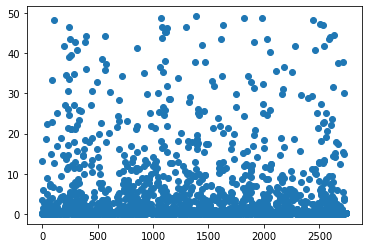

In [125]:
print(new_test_loss)
print(np.sum(downsampled_kin[test_ind]))
fig, ax = plt.subplots()
ax.scatter(range(0, len(downsampled_kin[test_ind]), 1), downsampled_kin[test_ind])
plt.show()

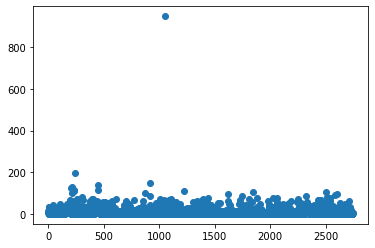

tensor(9.5448)


In [126]:
kin_x_dot = test_x[:,[0]]*torch.cos(test_x[:,[1]])
# print(len(kin_x_dot))
kin_y_dot = test_x[:,[0]]*torch.sin(test_x[:,[1]])
kin_error = torch.sum(torch.square(kin_x_dot - y[test_ind][:,[0]]))+  torch.sum(torch.square(kin_y_dot - y[test_ind][:,[1]]))  

fig, ax = plt.subplots()
ax.scatter(range(0, len(kin_x_dot), 1), torch.square(kin_x_dot - y[test_ind][:,[0]])+torch.square(kin_y_dot - y[test_ind][:,[1]]))
plt.show()

print(kin_error/len(test_x))

In [127]:
#retrain network on downsampled x
# train_x = x[0:9000] #select 9000 random samples instead 

#reinit model
model = Net(5, 36, 3)

ind = torch.randperm(len(downsampled_x))[:int(0.7*len(downsampled_x))] #there are alot of duplicates
# print(len(ind.tolist()))
train_x = downsampled_x[ind]
rho = 1
total_num = list(range(0, len(downsampled_x)))
test_ind =  list(set(total_num) - set(ind.tolist()))
# print(len(test_y))
# print (len(test_ind))
test_x = downsampled_x[test_ind]
print(len(test_x))
loss_arr = []
max_iters = 1500
test_loss_arr = []
j = 0
i = 0
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
while i < max_iters:
#     print (ind)
    train_y = model(train_x)
    l2loss = torch.sum(torch.square(train_y[:,[0,1]] - downsampled_y[ind][:,[0,1]]) + rho*torch.square(train_y[:,[2]] - y[ind][:,[2]])) / len(train_y)
    optimizer.zero_grad()
    l2loss.backward()
    optimizer.step()
    loss_arr.append(l2loss.item())
    if (j %50 == 0):
        test_y = model(test_x)
        l2loss_test = torch.sum(torch.square(test_y - downsampled_y[test_ind])) / len(test_y)
        test_loss_arr.append(l2loss_test)
        
    j += 1
    i += 1
    
  


2744


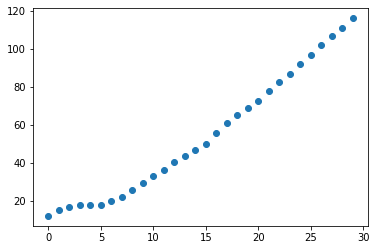

In [128]:

new_test_loss = [value.detach().numpy() for value in test_loss_arr]

fig, ax = plt.subplots()
ax.scatter(range(0, len(new_test_loss), 1), new_test_loss)
plt.show()

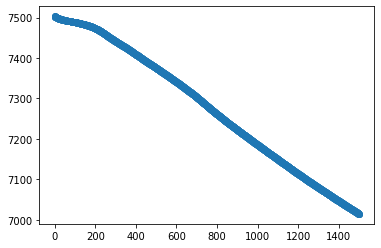

In [129]:
fig, ax = plt.subplots()
ax.scatter(range(0, len(loss_arr), 1), loss_arr)
plt.show()

In [130]:
#yaw kinematic error
length = 0.33655
print(len(downsampled_x))
kin_yaw_dot = downsampled_x[:,[0]] / (length / torch.tan(downsampled_x[:,[2]]))
yaw_error_arr = torch.square(kin_yaw_dot - downsampled_y[:,[2]])
print(len(yaw_error_arr))

9146
9146


In [131]:
print(yaw_error_arr[len(yaw_error_arr)-2])

tensor([0.0001])


In [132]:
print(downsampled_x[len(yaw_error_arr)-2,[0]])
print(downsampled_x[len(yaw_error_arr)-2,[2]])
print(y[ind][len(yaw_error_arr)-2,[2]])

tensor([0.3075])
tensor([0.])


IndexError: index 9144 is out of bounds for dimension 0 with size 6402

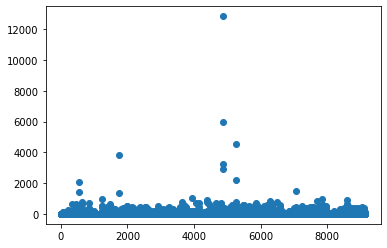

In [133]:
fig, ax = plt.subplots()
ax.scatter(range(0, len(yaw_error_arr), 1), yaw_error_arr)
plt.show()

9146
(array([8211,  400,  477,   58]), array([     0,     50,    100,    500, 100000]))
tensor([[ 4.0518,  5.3473, -0.0069],
        [-2.1956, -2.8986,  0.0479],
        [ 1.3602,  1.7957,  0.0561],
        ...,
        [-0.1569,  0.7824,  4.9057],
        [-0.0672,  1.1187,  3.6651],
        [-0.1979,  0.9264,  0.2459]])


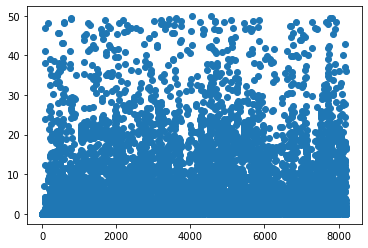

In [135]:
np_yaw_err = yaw_error_arr.numpy()
print(len(np_yaw_err))
hist = np.histogram(np_yaw_err, bins=[0, 50, 100, 500, 100000])
print(hist)
nice_ind = []
for i, val in enumerate(np_yaw_err):
    if val < 50:
        nice_ind.append(i)

# print(bad_ind)
# print(len(bad_ind))

#now we have all the bad ind, renomve from all data

double_downsampled_yaw = y[nice_ind,:]
# print(double_downsampled_yaw)
# print(len(double_downsampled_yaw))

print(double_downsampled_yaw)
fig, ax = plt.subplots()
ax.scatter(list(range(0, len(yaw_error_arr[nice_ind]), 1)), yaw_error_arr[nice_ind])
plt.show()

In [137]:
double_downsampled_x = downsampled_x[nice_ind,:]
double_downsampled_y = downsampled_y[nice_ind,:]
double_downsampled_kin = downsampled_kin[nice_ind,:]
#already how double downsampled yaw
print(len(double_downsampled_y))
print (len(downsampled_x))

8211
9146


In [138]:
#retrain network on downsampled x
# train_x = x[0:9000] #select 9000 random samples instead 

#reinit model
model = Net(5, 36, 3)

ind = torch.randperm(len(double_downsampled_x))[:int(0.7*len(double_downsampled_x))] #there are alot of duplicates
# print(len(ind.tolist()))
train_x = double_downsampled_x[ind]
rho = 1
total_num = list(range(0, len(double_downsampled_x)))
test_ind =  list(set(total_num) - set(ind.tolist()))
# print(len(test_y))
# print (len(test_ind))
test_x = double_downsampled_x[test_ind]
print(len(test_x))
loss_arr = []
max_iters = 1500
test_loss_arr = []
j = 0
i = 0
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
while i < max_iters:
#     print (ind)
    train_y = model(train_x)
    l2loss = torch.sum(torch.square(train_y[:,[0,1]] - double_downsampled_y[ind][:,[0,1]]) + rho*torch.square(train_y[:,[2]] - double_downsampled_y[ind][:,[2]])) / len(train_y)
    optimizer.zero_grad()
    l2loss.backward()
    optimizer.step()
    loss_arr.append(l2loss.item())
    if (j %50 == 0):
        test_y = model(test_x)
        l2loss_test = torch.sum(torch.square(test_y - double_downsampled_y[test_ind]))/len(test_y)
        test_loss_arr.append(l2loss_test)
    j += 1
    i += 1
    
  


2464


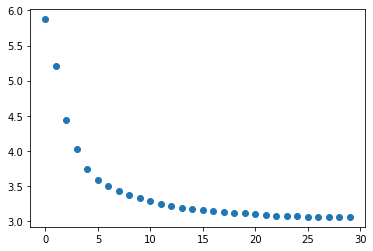

In [139]:
new_test_loss = [value.detach().numpy() for value in test_loss_arr]

fig, ax = plt.subplots()
ax.scatter(range(0, len(new_test_loss), 1), new_test_loss)
plt.show()

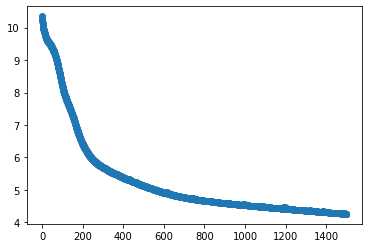

In [140]:
fig, ax = plt.subplots()
ax.scatter(range(0, len(loss_arr), 1), loss_arr)
plt.show()

In [149]:
print (np.min(loss_arr))
print (np.argmin(loss_arr))

4.260425090789795
1497


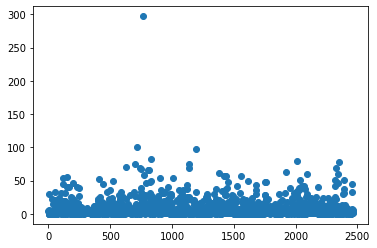

tensor(6.5995)


In [145]:
kin_x_dot = test_x[:,[0]]*torch.cos(test_x[:,[1]])
# print(len(kin_x_dot))
kin_y_dot = test_x[:,[0]]*torch.sin(test_x[:,[1]])
kin_error = torch.sum(torch.square(kin_x_dot - y[test_ind][:,[0]]))+  torch.sum(torch.square(kin_y_dot - y[test_ind][:,[1]]))  

fig, ax = plt.subplots()
ax.scatter(range(0, len(kin_x_dot), 1), torch.square(kin_x_dot - y[test_ind][:,[0]])+torch.square(kin_y_dot - y[test_ind][:,[1]]))
plt.show()

print(kin_error/len(test_x))

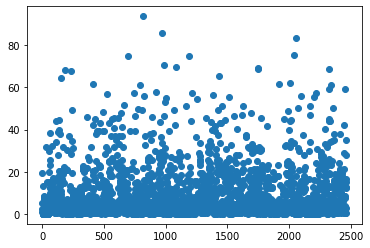

tensor([9.4460])


In [158]:
kin_x_dot = double_downsampled_x[test_ind][:,[0]]*torch.cos(double_downsampled_x[test_ind][:,[1]])
# print(len(kin_x_dot))
kin_y_dot = double_downsampled_x[test_ind][:,[0]]*torch.sin(double_downsampled_x[test_ind][:,[1]])
kin_t_dot = double_downsampled_x[test_ind][:,[0]]*torch.tan(double_downsampled_x[test_ind][:,[2]])/0.33
kin_error = torch.sum(torch.square(kin_x_dot - double_downsampled_y[test_ind][:,[0]]))+  torch.sum(torch.square(kin_y_dot - double_downsampled_y[test_ind][:,[1]])+torch.sum(torch.square(kin_t_dot - double_downsampled_y[test_ind][:,[2]])))  

total_error_arr = torch.square(kin_x_dot - double_downsampled_y[test_ind][:,[0]])+torch.square(kin_y_dot - double_downsampled_y[test_ind][:,[1]]) +torch.square(kin_t_dot - double_downsampled_y[test_ind][:,[2]])
fig, ax = plt.subplots()
ax.scatter(range(0, len(kin_x_dot), 1), torch.square(kin_x_dot - double_downsampled_y[test_ind][:,[0]])+torch.square(kin_y_dot - double_downsampled_y[test_ind][:,[1]]) +torch.square(kin_t_dot - double_downsampled_y[test_ind][:,[2]]))
plt.show()

print(sum(total_error_arr)/len(test_x))
